In [8]:
import matplotlib.pyplot as plt   
import numpy as np   
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

from keras.layers.core import Dense,Activation,Dropout
from keras.layers import LSTM 
from keras.models import Sequential

In [9]:
data = pd.read_csv('stock.csv')
data = data[['Open','High','Low','Volume','Close']]
data.head()

,Open,High,Low,Volume,Close
0,11727.139648,11804.589844,11627.530273,4930250000,11662.790039
1,11905.570313,11988.429688,11754.280273,5093960000,11984.519531
2,11790.679688,11826.219727,11381.690430,5064120000,11418.150391
3,11364.400391,11562.820313,11313.309570,5154410000,11388.500000
4,11542.669922,11552.209961,11035.690430,5434370000,11354.620117


In [11]:
sequence_length = 21
n_features = len(data.columns)
val_ratio = 0.1
n_epochs = 300
batch_size = 512

In [13]:
data = data.iloc[:,:].values
data_processed = []
for index in range(len(data)-sequence_length):
    data_processed.append(data[index:index+sequence_length])
data_processed = np.array(data_processed)

In [14]:
val_split  = round((1-val_ratio)*data_processed.shape[0])
train = data_processed[:int(val_split),:]
val = data_processed[int(val_split):,:]
print('Training data:{}'.format(train.shape))
print('vali data:{}'.format(val.shape))

Training data:(207, 21, 5)
vali data:(23, 21, 5)


In [15]:
train_samples, train_nx, train_ny = train.shape
val_samples, val_nx, val_ny = val.shape

train = train.reshape((train_samples, train_nx * train_ny))
val = val.reshape((val_samples, val_nx * val_ny))

preprocessor = MinMaxScaler().fit(train)
train = preprocessor.transform(train)
val = preprocessor.transform(val)

train = train.reshape((train_samples, train_nx, train_ny))
val = val.reshape((val_samples, val_nx, val_ny))

In [16]:
X_train = train[:, : -1]
y_train = train[:, -1][: ,-1]
X_val = val[:, : -1]
y_val = val[:, -1][ : ,-1]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], n_features))

In [19]:
model = Sequential([
    LSTM(input_shape=(X_train.shape[1:]),units = 128,return_sequences=True),
    Dropout(0.5),
    LSTM(128,return_sequences=False),
    Dropout(0.25),
    Dense(units=1),
    Activation('linear')
    
])
model.compile(loss="mse",optimizer="adam")
history = model.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/300
1/1 - 6s - loss: 0.2119 - 6s/epoch - 6s/step
Epoch 2/300
1/1 - 0s - loss: 0.0670 - 137ms/epoch - 137ms/step
Epoch 3/300
1/1 - 0s - loss: 0.0275 - 135ms/epoch - 135ms/step
Epoch 4/300
1/1 - 0s - loss: 0.0717 - 115ms/epoch - 115ms/step
Epoch 5/300
1/1 - 0s - loss: 0.0531 - 120ms/epoch - 120ms/step
Epoch 6/300
1/1 - 0s - loss: 0.0272 - 113ms/epoch - 113ms/step
Epoch 7/300
1/1 - 0s - loss: 0.0237 - 140ms/epoch - 140ms/step
Epoch 8/300
1/1 - 0s - loss: 0.0255 - 131ms/epoch - 131ms/step
Epoch 9/300
1/1 - 0s - loss: 0.0305 - 112ms/epoch - 112ms/step
Epoch 10/300
1/1 - 0s - loss: 0.0338 - 113ms/epoch - 113ms/step
Epoch 11/300
1/1 - 0s - loss: 0.0347 - 122ms/epoch - 122ms/step
Epoch 12/300
1/1 - 0s - loss: 0.0325 - 137ms/epoch - 137ms/step
Epoch 13/300
1/1 - 0s - loss: 0.0295 - 117ms/epoch - 117ms/step
Epoch 14/300
1/1 - 0s - loss: 0.0219 - 116ms/epoch - 116ms/step
Epoch 15/300
1/1 - 0s - loss: 0.0208 - 121ms/epoch - 121ms/step
Epoch 16/300
1/1 - 0s - loss: 0.0200 - 136ms/epoch - 13

In [20]:
preds_val = model.predict(X_val)
diff = []
for i in range(len(y_val)):
    pred = preds_val[i][0]
    diff.append(y_val[i] - pred)

1/1 [==============================] - 1s 1s/step


In [21]:
real_min = preprocessor.data_min_[104]
real_max = preprocessor.data_max_[104]
print(preprocessor.data_min_[104])
print(preprocessor.data_max_[104])

preds_real = preds_val * (real_max - real_min) + real_min
y_val_real = y_val * (real_max - real_min) + real_min

10213.290039
13128.049805


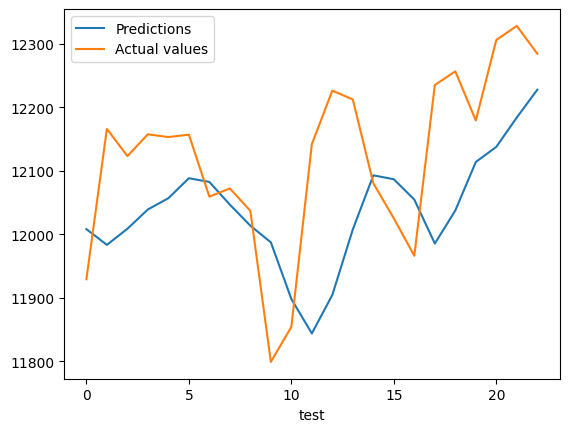

In [22]:
plt.plot(preds_real, label='Predictions')
plt.plot(y_val_real, label='Actual values')
plt.xlabel('test')
plt.legend(loc=0)
plt.show()